In [ ]:
# Instalar Java y Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar -xvzf spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark

# Configurar entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

# Inicializar findspark y crear sesión
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ETL E-commerce").getOrCreate()

print("✅ Spark instalado y listo.")


spark-3.2.1-bin-hadoop2.7/
spark-3.2.1-bin-hadoop2.7/LICENSE
spark-3.2.1-bin-hadoop2.7/NOTICE
spark-3.2.1-bin-hadoop2.7/R/
spark-3.2.1-bin-hadoop2.7/R/lib/
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/DESCRIPTION
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/INDEX
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/Meta/
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/Meta/Rd.rds
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/Meta/features.rds
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/Meta/hsearch.rds
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/Meta/links.rds
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/Meta/nsInfo.rds
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/Meta/package.rds
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/NAMESPACE
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/R/
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/R/SparkR
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/R/SparkR.rdb
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/R/SparkR.rdx
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/help/
spark-3.2.1-bin-hadoop2.7/R/lib/SparkR/help/An

In [6]:
df_raw = spark.read.csv("ventas_ecommerce.csv", header=True, inferSchema=True)
df_raw.show(5)
df_raw.printSchema()

+---------+---------+--------------------+--------+----------------+---------+----------+-----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|TotalAmount|       Country|
+---------+---------+--------------------+--------+----------------+---------+----------+-----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2.55|     17850|       15.3|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3.39|     17850|      20.34|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/2010 08:26|     2.75|     17850|       22.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|01/12/2010 08:26|     3.39|     17850|      20.34|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|01/12/2010 08:26|     3.39|     17850|      20.34|United Kingdom|
+---------+---------+--------------------+--------+-------------

In [7]:
from pyspark.sql.functions import to_timestamp, col, lower, trim

# 1. Limpiar y normalizar columnas
df_clean = df_raw \
    .withColumn("InvoiceDate", to_timestamp("InvoiceDate", "d/MM/yyyy HH:mm")) \
    .withColumn("Description", trim(lower(col("Description")))) \
    .withColumn("Country", trim(lower(col("Country"))))

# 2. Filtrar datos nulos y cantidades positivas
df_clean = df_clean.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))

# 3. Calcular columna "CalculatedTotal"
df_clean = df_clean.withColumn("CalculatedTotal", col("Quantity") * col("UnitPrice"))

df_clean.select("InvoiceNo", "InvoiceDate", "Description", "Quantity", "UnitPrice", "CalculatedTotal").show(5)


+---------+-------------------+--------------------+--------+---------+------------------+
|InvoiceNo|        InvoiceDate|         Description|Quantity|UnitPrice|   CalculatedTotal|
+---------+-------------------+--------------------+--------+---------+------------------+
|   536365|2010-12-01 08:26:00|white hanging hea...|       6|     2.55|15.299999999999999|
|   536365|2010-12-01 08:26:00| white metal lantern|       6|     3.39|             20.34|
|   536365|2010-12-01 08:26:00|cream cupid heart...|       8|     2.75|              22.0|
|   536365|2010-12-01 08:26:00|knitted union fla...|       6|     3.39|             20.34|
|   536365|2010-12-01 08:26:00|red woolly hottie...|       6|     3.39|             20.34|
+---------+-------------------+--------------------+--------+---------+------------------+
only showing top 5 rows



In [12]:
# 1. Guardar en una sola partición
df_clean.coalesce(1).write.csv("ventas_temp", header=True, mode="overwrite")

In [13]:
# 2. Buscar el nombre real del archivo generado
import os
import shutil

# Listar archivos de la carpeta
for file in os.listdir("ventas_temp"):
    if file.endswith(".csv"):
        original_path = f"ventas_temp/{file}"
        break

# 3. Renombrar
new_path = "ventas_ecommerce_limpio.csv"
shutil.move(original_path, new_path)


'ventas_ecommerce_limpio.csv'

In [14]:
# 4. Descargar el archivo
from google.colab import files
files.download("ventas_ecommerce_limpio.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

"""
DAG: etl_ecommerce_dag
Programado para correr: Diariamente a las 6:00 AM

Tareas:
1. extraer_datos_csv(): descargar el archivo de ventas desde FTP o S3
2. transformar_datos(): limpieza, validación y cálculo de totales
3. cargar_en_storage(): guardar archivo limpio en Google Cloud Storage o Redshift
4. notificar_exito(): enviar mensaje por email o Slack

Dependencias:
extraer_datos_csv >> transformar_datos >> cargar_en_storage >> notificar_exito
"""


In [17]:
def extraer_datos():
    print("Extrayendo datos desde archivo CSV...")
    df = spark.read.csv("ventas_ecommerce.csv", header=True, inferSchema=True)
    return df

def transformar_datos(df):
    from pyspark.sql.functions import to_timestamp, col, lower, trim
    print("Transformando datos...")
    return df.withColumn("InvoiceDate", to_timestamp("InvoiceDate", "d/MM/yyyy HH:mm")) \
             .withColumn("Description", trim(lower(col("Description")))) \
             .withColumn("CalculatedTotal", col("Quantity") * col("UnitPrice"))

def guardar_datos(df):
    print("Guardando archivo limpio...")
    df.coalesce(1).write.csv("ventas_etl_final", header=True, mode="overwrite")

def ejecutar_etl():
    df = extraer_datos()
    df_transformado = transformar_datos(df)
    guardar_datos(df_transformado)
    print("ETL completado correctamente.")

ejecutar_etl()


Extrayendo datos desde archivo CSV...
Transformando datos...
Guardando archivo limpio...
ETL completado correctamente.


In [21]:
# Repartir en más particiones para paralelismo
df_repartido = df_clean.repartition(8)  # Número de particiones depende del tamaño y entorno

In [19]:
df_repartido.cache()

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, UnitPrice: double, CustomerID: int, TotalAmount: double, Country: string, CalculatedTotal: double]

In [20]:
df_repartido.coalesce(1).write.csv("ventas_final", header=True, mode="overwrite")

In [22]:
from pyspark.sql.functions import sum as _sum

ventas_por_producto = df_clean.groupBy("Description") \
                               .agg(_sum("CalculatedTotal").alias("TotalVentas")) \
                               .orderBy("TotalVentas", ascending=False)

ventas_por_producto.show(10)

+--------------------+------------------+
|         Description|       TotalVentas|
+--------------------+------------------+
|      dotcom postage|206248.77000000008|
|regency cakestand...|174484.73999999967|
|paper craft , lit...|          168469.6|
|white hanging hea...|106292.76999999944|
|       party bunting| 99504.33000000025|
|jumbo bag red ret...| 94340.05000000072|
|medium ceramic to...| 81700.92000000003|
|              manual|          78112.82|
|             postage|          78101.88|
|  rabbit night light|  66964.9900000002|
+--------------------+------------------+
only showing top 10 rows



In [23]:
ventas_pd = ventas_por_producto.toPandas()

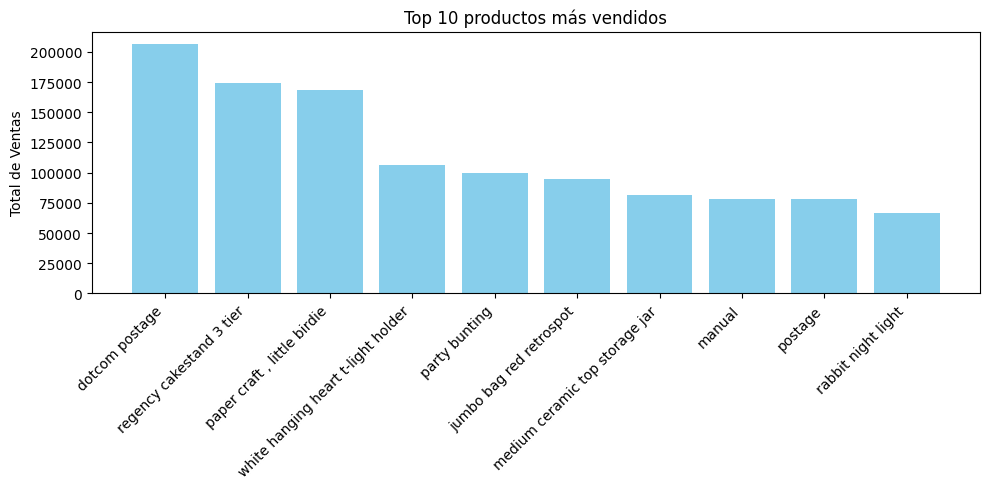

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(ventas_pd["Description"][:10], ventas_pd["TotalVentas"][:10], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 productos más vendidos")
plt.ylabel("Total de Ventas")
plt.tight_layout()
plt.show()